# Deep learning models for GTSRB dataset

### Imports

In [86]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
import collections

import os
import numpy as np

from collections import Counter

# plotting
import matplotlib.pyplot as plt

# to display confusion matrix
import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Aux functions

In [107]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == classNames

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the imager to the desired size
    return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def convert_to_png(data_path, convert=True):
    if convert:
        for i in range (NUM_CLASSES):
            image_path = os.path.join(data_path, format(i, '05d')) #Datasets/images/00001
            files = os.listdir(image_path) #['00001_00000.ppm', ...]

            for file in files:
                try:
                    image = Image.open(os.path.join(image_path,file))
                    image.save(f"{image_path}/{file.split('.')[0]}.png")
                except:
                    pass
        print(f'Finished converting all files in {data_path} into png files.')
    else:
        print(f'Dataset: {data_path} remains unchanged.')

def show_batch(image_batch, label_batch, cols = 8):
    rows = int(32 / cols)
    if rows * cols < 32:
        rows += 1
    width = 3 * rows
    height = 3 * cols


    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(32):
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()
    plt.show()

def show_confusion_matrix(model, dataset):

    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)

        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]

    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(43), range(43))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='d') # font size

    plt.show()

    res_correct = Counter()
    res_incorrect = Counter()
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

### Useful Variables

In [108]:
BATCH_SIZE = 64
IMAGE_SIZE = 32
NUM_MODELS = 3
KERNEL_SIZE = (5,5)

TRAIN_PATH = '../Datasets/train_images'
TEST_PATH = '../Datasets/test_images'
CALLBACKS_PATH = '../Callbacks/Version'

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Prepare to load images

In [109]:
# GET CLASS NAMES AND TOTAL CLASSES
classNames = np.array(os.listdir(TRAIN_PATH))
NUM_CLASSES = len(classNames)

# CONVERT IMAGES TO PNG
convert_to_png(TRAIN_PATH, False)
convert_to_png(TEST_PATH, False)

Dataset: /content/Datasets/train_images remains unchanged.
Dataset: /content/Datasets/test_images remains unchanged.


### Preparing datasets

In [110]:
train_listset = tf.data.Dataset.list_files(f'{TRAIN_PATH}/*/*.png')
train_dataset_length = train_listset.cardinality().numpy()
train_dataset = train_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_listset = tf.data.Dataset.list_files(f'{TEST_PATH}/*/*.png')
test_dataset_length = test_listset.cardinality().numpy()
test_dataset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

print(f"Train length: {train_dataset_length}")
print(f"Test length: {test_dataset_length}")

Train length: 39209
Test length: 12630


#### Data processing functions

In [111]:
def process_data(dataset, length):
    processed_data = dataset

    processed_data = processed_data.cache()
    processed_data = processed_data.shuffle(buffer_size = length)
    processed_data = processed_data.batch(batch_size = BATCH_SIZE)
    processed_data = processed_data.prefetch(buffer_size = AUTOTUNE)
    return processed_data

In [112]:
train_dataset_proc = process_data(train_dataset, train_dataset_length)
test_dataset_proc = process_data(test_dataset, test_dataset_length)

### Show a batch of test images

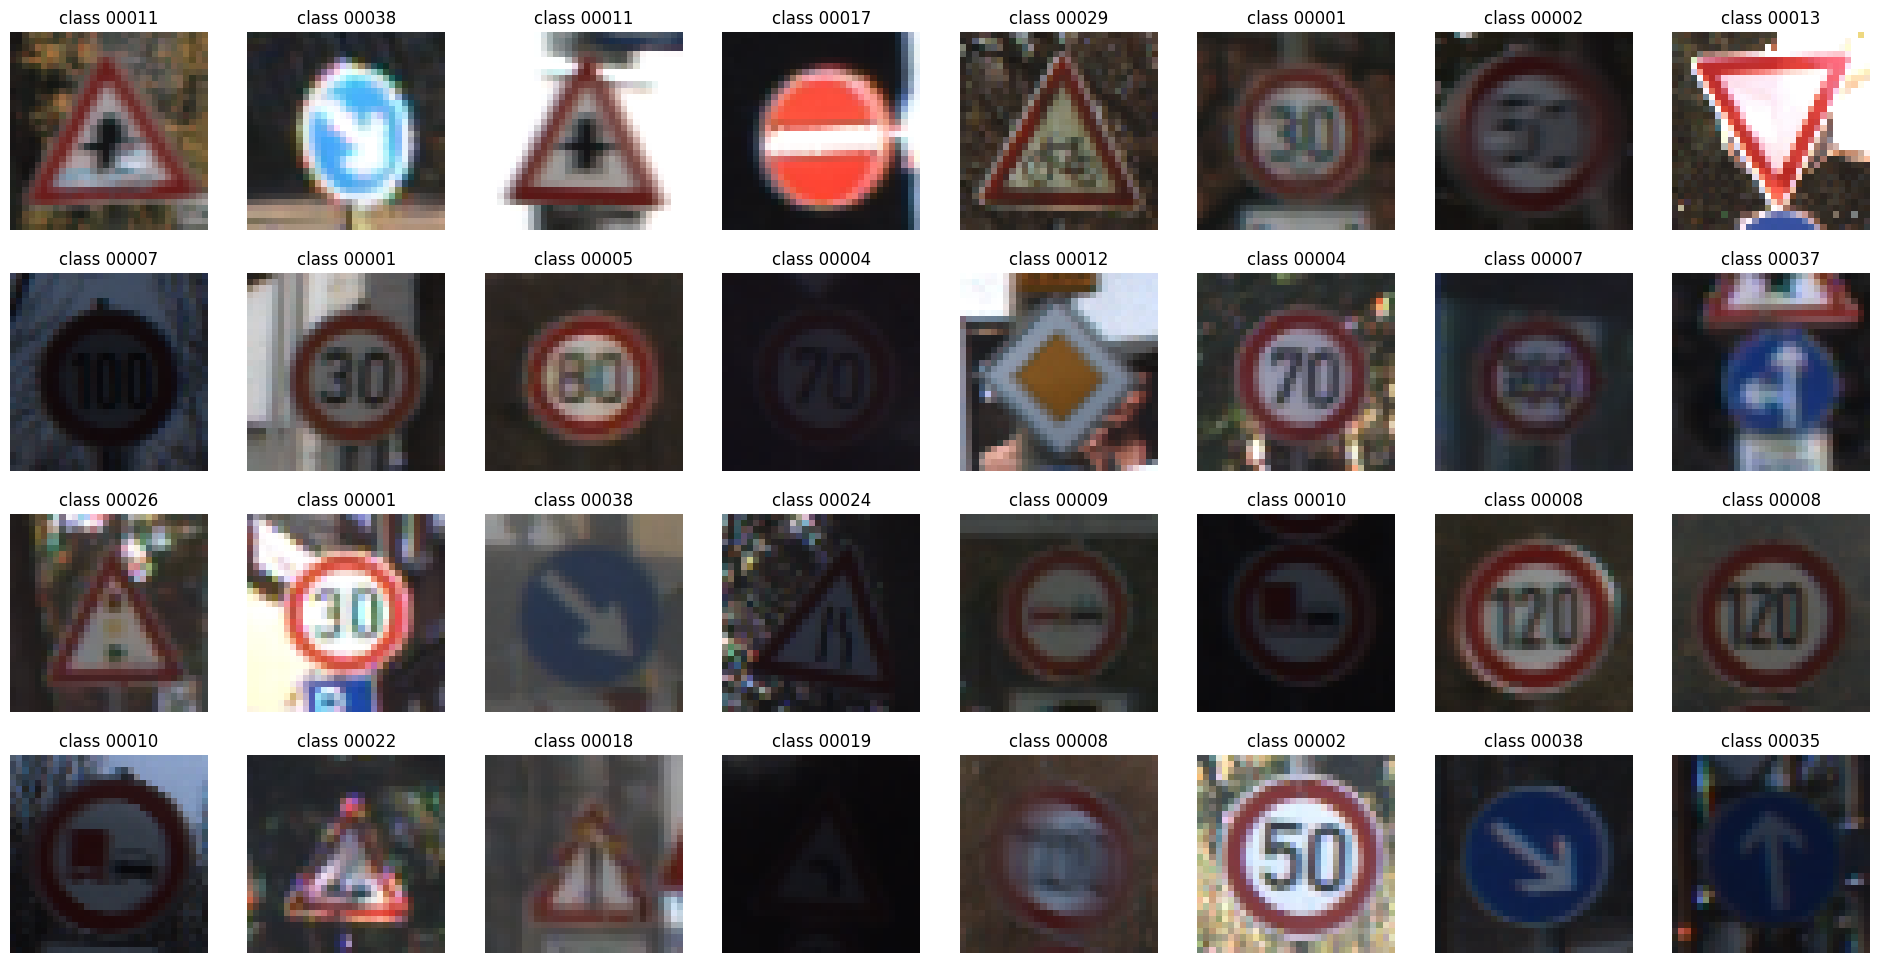

<Figure size 640x480 with 0 Axes>

In [113]:
image_batch, label_batch = next(iter((test_dataset_proc)))
show_batch(image_batch, label_batch.numpy())

### Creating the ensemble

In [114]:
def prepare_callbacks(file_path):
    checkpointer = ModelCheckpoint(filepath= file_path,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

def create_model(class_count, img_size, channels):
    modelLogits = Sequential()

    modelLogits.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(32, 32, 3)))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Conv2D(196,KERNEL_SIZE))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Conv2D(256,KERNEL_SIZE))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Flatten())
    modelLogits.add(LeakyReLU(alpha=0.00))
    modelLogits.add(Dense(384))
    modelLogits.add(LeakyReLU(alpha=0.00))
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Dense(43))

    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

def prepare_models():
    models = []

    for i in range(NUM_MODELS):
        model, modelL = create_model(NUM_CLASSES, IMAGE_SIZE, 3)
        models.append([model, modelL])

    load_weights(models)

    return models

def load_weights(models):
    for i in range(NUM_MODELS):
        file_path = f"{CALLBACKS_PATH}{i+1}/callbackV{i+1}_00/cp.ckpt"
        models[i][0].load_weights(file_path)
        models[i][0].save('../Results/temp.hdf5')
        models[i][1].load_weights('../Results/temp.hdf5', by_name=True)


def evaluate_models(models):
    accuracy = 0

    for i in range(NUM_MODELS):
        eval_ = models[i][0].evaluate(test_dataset_proc, verbose = 2)
        accuracy += eval_[1]

    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')

def get_labels_logits_and_preds(models):
    preds = [[] for _ in range(NUM_MODELS)]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in test_dataset_proc.take(-1):
        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):
            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))
    labels = [np.argmax(i) for i in labels]

    return labels, logits, preds

def get_class_preds(preds):

    class_preds = []

    for i in range(test_dataset_length):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)

    return class_preds

def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(test_dataset_length):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)

def get_stats(labels, class_preds, class_logits):
    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(test_dataset_length):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1

    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]

Load previously trained NNs

In [115]:
models = prepare_models()

Prepare data for stacked ensemble and get stats for predictions

In [116]:
labels, logits, preds = get_labels_logits_and_preds(models)
class_preds = get_class_preds(preds)
class_logits = get_class_from_sum_of_logits(logits)

res = get_stats(labels, class_preds, class_logits)
print(res, res[6]/res[0])

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 92ms/step
[12630, 2, 12141, 2, 53, 432, 4, 12626] 0.00031670625494853525


In [117]:
test_logits_preds = []

for i in range(test_dataset_length):
    aux = []
    for m in range(NUM_MODELS):
        aux.extend(logits[m][i])
    test_logits_preds.append(aux)

In [118]:
logits_train = [[] for _ in range(NUM_MODELS)]
labels_aux = []
for images, labs in train_dataset_proc.take(-1):

    labels_aux.extend(labs.numpy())
    for i in range(NUM_MODELS):

        logits_train[i].extend(models[i][1].predict(images))

labels_train = [np.argmax(i) for i in labels_aux]

2/2 [==============================] - 0s 6ms/step


In [119]:
train_logits_preds = []

for i in range(train_dataset_length):

    aux = []

    for m in range(NUM_MODELS):

        aux.extend(logits_train[m][i])

    train_logits_preds.append(aux)

Prepare stacked ensemble model

In [120]:
stack_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(len(train_logits_preds[0]),)),

    tf.keras.layers.Dense(256),
    BatchNormalization(),LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128),
    BatchNormalization(),LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64),
    BatchNormalization(),LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(43, activation='softmax')
])

print('Training stack model')
callbacks = prepare_callbacks('../Callbacks/callbackV4_00')
stack_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Training stack model


In [121]:
train_logits_preds = np.asarray(train_logits_preds)

In [122]:
labels_train = np.asarray(labels_train)

In [123]:
print(len(test_logits_preds))

12630


In [124]:
hist = stack_model.fit(np.asarray(train_logits_preds),
    np.asarray(labels_train),
    epochs=10,
    batch_size=BATCH_SIZE)

Epoch 1/10
613/613 [==============================] - 4s 4ms/step - loss: 2.6997 - accuracy: 0.3585
Epoch 2/10
613/613 [==============================] - 3s 4ms/step - loss: 1.5578 - accuracy: 0.6877
Epoch 3/10
613/613 [==============================] - 2s 4ms/step - loss: 1.1013 - accuracy: 0.7776
Epoch 4/10
613/613 [==============================] - 2s 4ms/step - loss: 0.8172 - accuracy: 0.8391
Epoch 5/10
613/613 [==============================] - 2s 4ms/step - loss: 0.6135 - accuracy: 0.8770
Epoch 6/10
613/613 [==============================] - 3s 4ms/step - loss: 0.4818 - accuracy: 0.9026
Epoch 7/10
613/613 [==============================] - 3s 4ms/step - loss: 0.3807 - accuracy: 0.9244
Epoch 8/10
613/613 [==============================] - 2s 4ms/step - loss: 0.3150 - accuracy: 0.9356
Epoch 9/10
613/613 [==============================] - 3s 4ms/step - loss: 0.2565 - accuracy: 0.9499
Epoch 10/10
613/613 [==============================] - 2s 4ms/step - loss: 0.2181 - accuracy: 0.9569

In [125]:
pred = stack_model.predict(np.asarray(test_logits_preds))

correct = 0

for i in range(test_dataset_length):
    if np.argmax(pred[i]) == labels[i] :
        correct += 1


395/395 [==============================] - 1s 1ms/step


In [129]:
correct = 0

for i in range(test_dataset_length):
    if np.argmax(pred[i]) == labels[i] :
        correct += 1


print(f'Accuracy: {correct/len(pred)*100:.3f}')

Accuracy: 98.583
